<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/LSTM_403.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 403
Start with LSTM 201 and modify it to use our updated code infrastructure.

In [10]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=64
DROP=0.4
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [13]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP) )#bi
    rnn2_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) )#bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [14]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [15]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [16]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [17]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          1040      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         41472     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
___________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 77s 144ms/step - loss: 0.6163 - accuracy: 0.6749 - val_loss: 0.5811 - val_accuracy: 0.7163


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 61s 135ms/step - loss: 0.6024 - accuracy: 0.6824 - val_loss: 0.6191 - val_accuracy: 0.6840
Epoch 3/100
453/453 [==============================] - 62s 136ms/step - loss: 0.6207 - accuracy: 0.6810 - val_loss: 0.6025 - val_accuracy: 0.6890
Epoch 4/100
453/453 [==============================] - 62s 138ms/step - loss: 0.6080 - accuracy: 0.6943 - val_loss: 0.5928 - val_accuracy: 0.6934
Epoch 5/100
453/453 [==============================] - 62s 136ms/step - loss: 0.5933 - accuracy: 0.6901 - val_loss: 0.5828 - val_accuracy: 0.7138
Epoch 6/100
453/453 [==============================] - 61s 136ms/step - loss: 0.5801 - accuracy: 0.7005 - val_loss: 0.5410 - val_accuracy: 0.7294


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 7/100
453/453 [==============================] - 62s 136ms/step - loss: 0.5573 - accuracy: 0.7224 - val_loss: 0.5890 - val_accuracy: 0.6965
Epoch 8/100
453/453 [==============================] - 62s 137ms/step - loss: 0.5697 - accuracy: 0.7082 - val_loss: 0.5317 - val_accuracy: 0.7374


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 9/100
453/453 [==============================] - 63s 139ms/step - loss: 0.5670 - accuracy: 0.7075 - val_loss: 0.5126 - val_accuracy: 0.7678


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 10/100
453/453 [==============================] - 62s 137ms/step - loss: 0.5528 - accuracy: 0.7228 - val_loss: 0.6033 - val_accuracy: 0.6716
Epoch 11/100
453/453 [==============================] - 62s 136ms/step - loss: 0.6001 - accuracy: 0.6843 - val_loss: 0.5570 - val_accuracy: 0.7405
Epoch 12/100
453/453 [==============================] - 61s 135ms/step - loss: 0.5699 - accuracy: 0.7132 - val_loss: 0.5985 - val_accuracy: 0.6853
Epoch 13/100
453/453 [==============================] - 60s 133ms/step - loss: 0.5869 - accuracy: 0.6943 - val_loss: 0.5816 - val_accuracy: 0.6903
Epoch 14/100
453/453 [==============================] - 61s 134ms/step - loss: 0.5757 - accuracy: 0.6987 - val_loss: 0.5553 - val_accuracy: 0.7281
Epoch 15/100
453/453 [==============================] - 61s 135ms/step - loss: 0.5642 - accuracy: 0.7182 - val_loss: 0.5208 - val_accuracy: 0.7523
Epoch 16/100
453/453 [==============================] - 61s 134ms/step - loss: 0.5415 - accuracy: 0.7331 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 18/100
453/453 [==============================] - 62s 137ms/step - loss: 0.5286 - accuracy: 0.7413 - val_loss: 0.4714 - val_accuracy: 0.7790


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 19/100
453/453 [==============================] - 60s 132ms/step - loss: 0.4902 - accuracy: 0.7742 - val_loss: 0.4354 - val_accuracy: 0.7896


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 20/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4671 - accuracy: 0.7871 - val_loss: 0.4338 - val_accuracy: 0.7976


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 21/100
453/453 [==============================] - 60s 133ms/step - loss: 0.4418 - accuracy: 0.8054 - val_loss: 0.4685 - val_accuracy: 0.7852
Epoch 22/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4346 - accuracy: 0.8039 - val_loss: 0.4077 - val_accuracy: 0.8163


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 23/100
453/453 [==============================] - 60s 133ms/step - loss: 0.4204 - accuracy: 0.8133 - val_loss: 0.3956 - val_accuracy: 0.8262


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 24/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4189 - accuracy: 0.8167 - val_loss: 0.4049 - val_accuracy: 0.8237
Epoch 25/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4125 - accuracy: 0.8143 - val_loss: 0.3861 - val_accuracy: 0.8281


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 26/100
453/453 [==============================] - 61s 134ms/step - loss: 0.4057 - accuracy: 0.8203 - val_loss: 0.4308 - val_accuracy: 0.8026
Epoch 27/100
453/453 [==============================] - 62s 136ms/step - loss: 0.4115 - accuracy: 0.8161 - val_loss: 0.3751 - val_accuracy: 0.8392


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 28/100
453/453 [==============================] - 62s 136ms/step - loss: 0.4044 - accuracy: 0.8208 - val_loss: 0.3949 - val_accuracy: 0.8212
Epoch 29/100
453/453 [==============================] - 62s 137ms/step - loss: 0.4064 - accuracy: 0.8193 - val_loss: 0.4166 - val_accuracy: 0.8125
Epoch 30/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3931 - accuracy: 0.8254 - val_loss: 0.3750 - val_accuracy: 0.8386
Epoch 31/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3973 - accuracy: 0.8236 - val_loss: 0.3821 - val_accuracy: 0.8343
Epoch 32/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3921 - accuracy: 0.8253 - val_loss: 0.3664 - val_accuracy: 0.8405


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 33/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3920 - accuracy: 0.8332 - val_loss: 0.4005 - val_accuracy: 0.8163
Epoch 34/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3784 - accuracy: 0.8397 - val_loss: 0.5015 - val_accuracy: 0.7666
Epoch 35/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3794 - accuracy: 0.8378 - val_loss: 0.3663 - val_accuracy: 0.8430


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 36/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3865 - accuracy: 0.8305 - val_loss: 0.3890 - val_accuracy: 0.8287
Epoch 37/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3957 - accuracy: 0.8262 - val_loss: 0.3664 - val_accuracy: 0.8399
Epoch 38/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3803 - accuracy: 0.8360 - val_loss: 0.3578 - val_accuracy: 0.8454


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 39/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3809 - accuracy: 0.8323 - val_loss: 0.3553 - val_accuracy: 0.8355
Epoch 40/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3716 - accuracy: 0.8408 - val_loss: 0.3584 - val_accuracy: 0.8399
Epoch 41/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3734 - accuracy: 0.8336 - val_loss: 0.3810 - val_accuracy: 0.8380
Epoch 42/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3766 - accuracy: 0.8388 - val_loss: 0.3822 - val_accuracy: 0.8324
Epoch 43/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3657 - accuracy: 0.8386 - val_loss: 0.3514 - val_accuracy: 0.8405
Epoch 44/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3572 - accuracy: 0.8480 - val_loss: 0.3578 - val_accuracy: 0.8374
Epoch 45/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3512 - accuracy: 0.8517 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 46/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3593 - accuracy: 0.8434 - val_loss: 0.3304 - val_accuracy: 0.8541
Epoch 47/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3549 - accuracy: 0.8458 - val_loss: 0.3258 - val_accuracy: 0.8610
Epoch 48/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3462 - accuracy: 0.8493 - val_loss: 0.3232 - val_accuracy: 0.8572
Epoch 49/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3488 - accuracy: 0.8526 - val_loss: 0.3288 - val_accuracy: 0.8585
Epoch 50/100
453/453 [==============================] - 62s 136ms/step - loss: 0.3412 - accuracy: 0.8557 - val_loss: 0.3261 - val_accuracy: 0.8591
Epoch 51/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3545 - accuracy: 0.8491 - val_loss: 0.3379 - val_accuracy: 0.8492
Epoch 52/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3340 - accuracy: 0.8567 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 55/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3273 - accuracy: 0.8622 - val_loss: 0.3132 - val_accuracy: 0.8684


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 56/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3322 - accuracy: 0.8622 - val_loss: 0.3110 - val_accuracy: 0.8659
Epoch 57/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3197 - accuracy: 0.8661 - val_loss: 0.3431 - val_accuracy: 0.8436
Epoch 58/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3128 - accuracy: 0.8700 - val_loss: 0.3105 - val_accuracy: 0.8678
Epoch 59/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3241 - accuracy: 0.8631 - val_loss: 0.3464 - val_accuracy: 0.8442
Epoch 60/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3215 - accuracy: 0.8698 - val_loss: 0.3112 - val_accuracy: 0.8684
Epoch 61/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3086 - accuracy: 0.8755 - val_loss: 0.3080 - val_accuracy: 0.8616
Epoch 62/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3142 - accuracy: 0.8694 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 63/100
453/453 [==============================] - 63s 139ms/step - loss: 0.3043 - accuracy: 0.8780 - val_loss: 0.3159 - val_accuracy: 0.8672
Epoch 64/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3047 - accuracy: 0.8780 - val_loss: 0.3174 - val_accuracy: 0.8665
Epoch 65/100
453/453 [==============================] - 62s 137ms/step - loss: 0.3010 - accuracy: 0.8795 - val_loss: 0.3142 - val_accuracy: 0.8690
Epoch 66/100
453/453 [==============================] - 62s 138ms/step - loss: 0.3047 - accuracy: 0.8773 - val_loss: 0.3187 - val_accuracy: 0.8665
Epoch 67/100
453/453 [==============================] - 63s 138ms/step - loss: 0.3004 - accuracy: 0.8772 - val_loss: 0.3266 - val_accuracy: 0.8554
Epoch 68/100
453/453 [==============================] - 63s 139ms/step - loss: 0.2989 - accuracy: 0.8806 - val_loss: 0.3368 - val_accuracy: 0.8579
Epoch 69/100
453/453 [==============================] - 62s 136ms/step - loss: 0.2806 - accuracy: 0.8888 - val_loss: 0

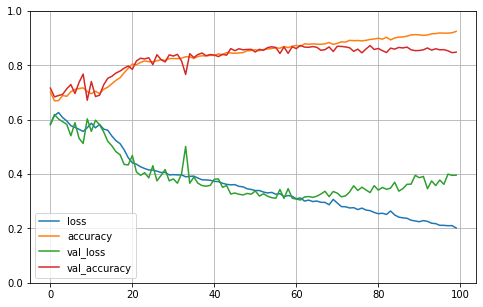

accuracy: 87.34%

1-way Cross Validation mean 87.34% (+/- 0.00%)
Done


In [18]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")